In [1]:
!pip install -q evaluate torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Datasets, Tokenizer, and Model

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_test.csv')

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Multi-Label Prediction

In [6]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

example = train_dataset[0]
example

{'text_cleaned': 'يلعن شرفك يا حكم!!!',
 'language': 'arabic',
 'directness_label': 2,
 'target_label': 2,
 'group_label': 12,
 'hatespeech': 0,
 'hatespeech.1': 0,
 'directness_label.1': 2,
 'target_label.1': 2,
 'group_label.1': 12,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 1,
 'sentiment_sadness': 0,
 'sentiment_shock': 0,
 'language_encoded': 2}

In [7]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 30702
    })
    validation: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 

In [8]:
example = dataset['train'][13000]
example

{'text_cleaned': "c'est un gros mongol quand même",
 'language': 'french',
 'directness_label': 0,
 'target_label': 3,
 'group_label': 8,
 'hatespeech': 1,
 'hatespeech.1': 1,
 'directness_label.1': 0,
 'target_label.1': 3,
 'group_label.1': 8,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 0,
 'sentiment_sadness': 0,
 'sentiment_shock': 1,
 'language_encoded': 1}

In [9]:
# Original binary labels
binary_label_columns = [
    'hatespeech',
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
]

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

# Create names for one-hot encoded binary labels
directness_binary_labels = [f'directness_label_{val}' for val in directness_values]
target_binary_labels = [f'target_label_{val}' for val in target_values]
group_binary_labels = [f'group_label_{val}' for val in group_values]

# Combine all binary label names
all_binary_labels = binary_label_columns + directness_binary_labels + target_binary_labels + group_binary_labels

# Update id2label and label2id
id2label = {idx:label for idx, label in enumerate(all_binary_labels)}
label2id = {label:idx for idx, label in enumerate(all_binary_labels)}

# The total number of binary labels
num_binary_labels = len(all_binary_labels)

print(f"Total number of binary labels: {num_binary_labels}")
print(f"All binary labels: {all_binary_labels}")

Total number of binary labels: 36
All binary labels: ['hatespeech', 'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger', 'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear', 'directness_label_0', 'directness_label_1', 'directness_label_2', 'target_label_0', 'target_label_1', 'target_label_2', 'target_label_3', 'target_label_4', 'target_label_5', 'target_label_6', 'group_label_0', 'group_label_1', 'group_label_2', 'group_label_3', 'group_label_4', 'group_label_5', 'group_label_6', 'group_label_7', 'group_label_8', 'group_label_9', 'group_label_10', 'group_label_11', 'group_label_12', 'group_label_13', 'group_label_14', 'group_label_15', 'group_label_16']


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-multilingual-cased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(all_binary_labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import torch
import numpy as np

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

def preprocess_multioutput_data(examples):
  # take a batch of texts
  text = [str(x) for x in examples["text_cleaned"]]
  # encode them, returning PyTorch tensors directly
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=150, return_tensors="pt")

  # Create a list of binary label tensors, starting with the 'hatespeech' label
  binary_labels_list = [
      torch.tensor(examples["hatespeech"])
  ]

  # Add other binary sentiment labels
  sentiment_labels = [
      "sentiment_anger",
      "sentiment_confusion",
      "sentiment_disgust",
      "sentiment_fear",
      "sentiment_indifference",
      "sentiment_normal",
      "sentiment_sadness",
      "sentiment_shock"
  ]
  for label in sentiment_labels:
      binary_labels_list.append(torch.tensor(examples[label]))


  # Perform one-hot encoding for multiclass labels and add to the list
  for i, val in enumerate(directness_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["directness_label"]]))

  for i, val in enumerate(target_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["target_label"]]))

  for i, val in enumerate(group_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["group_label"]]))


  # Stack all binary label tensors along dimension 1
  # Ensure all tensors in the list have the same length before stacking
  # (This should be guaranteed by the batching process, but it's good practice)
  labels_tensor = torch.stack(binary_labels_list, dim=1).float()


  # Add the stacked labels tensor to the encoding dictionary
  encoding['labels'] = labels_tensor

  return encoding

# Apply the preprocessing function with batching
encoded_dataset = dataset.map(preprocess_multioutput_data, batched=True, remove_columns=dataset['train'].column_names)


Map:   0%|          | 0/30702 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

In [12]:
from transformers import DistilBertForSequenceClassification
import torch.nn as nn
import torch
from transformers.modeling_outputs import SequenceClassifierOutput

class HierarchicalDistilBert(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        # Define a classification head for hatespeech (binary)
        # We use 2 output neurons for BCEWithLogitsLoss with target being [0, 1] or [1, 0]
        # or a single output neuron with target being 0 or 1.
        # Let's stick to a single output neuron and use BCEWithLogitsLoss with target 0 or 1.
        self.hatespeech_classifier = nn.Linear(config.dim, 1)

        # Define a classification head for the remaining labels
        # Subtract 1 for the hatespeech label from the total number of labels
        num_remaining_labels = config.num_labels - 1
        self.other_labels_classifier = nn.Linear(config.dim, num_remaining_labels)

        # Initialize weights and apply final activation (handled in forward pass)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None, # Labels should be of shape (batch_size, num_total_labels)
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Get the output from the base DistilBERT model
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

## Instantiate and train the custom model


In [14]:
# Unfreeze classifier, pooler, and layer 3, 4, and 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "distilbert" and "transformer.layer.5" in name:
    #     param.requires_grad = True
    # elif name.split(".")[0] == "distilbert" and "transformer.layer.4" in name:
    #     param.requires_grad = True
    # elif name.split(".")[0] == "distilbert" and "transformer.layer.3" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (91,812,096)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           27,684
├─Dropout: 1-4                                          --
Total params: 135,352,356
Trainable params: 7,706,148
Non-trainable params: 127,646,208

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction
import torch
import numpy as np

def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels.astype(int) # Ensure labels are integers
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'precision': precision,
               'recall': recall}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions

    # Ensure labels are a 2D numpy array of integers
    labels_np = np.array(p.label_ids)
    if labels_np.ndim == 1:
        # This might happen if the batch size is 1, reshape to (1, num_labels)
        labels_np = labels_np.reshape(1, -1)
    elif labels_np.ndim > 2:
        # Handle cases where labels might have extra dimensions unexpectedly
        # This might require more specific reshaping based on the actual structure
        # For now, let's assume the expected shape is (batch_size, num_labels)
        # and try to flatten and reshape if necessary.
        # A safer approach might be to raise an error or log a warning here.
        print(f"Warning: Unexpected label dimension: {labels_np.ndim}")
        # Attempt to flatten and reshape - adjust if your data structure is different
        labels_np = labels_np.reshape(labels_np.shape[0], -1)


    result = multi_label_metrics(
        predictions=preds,
        labels=labels_np)
    return result


In [16]:

from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

batch_size = 128
metric_name = "eval_f1"

args = TrainingArguments(
    f"distilbert-base-multilingual-cased_hierarchical", # Changed output directory name
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.02,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    report_to='none'
)

# Add EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.0
)

# Instantiate the HierarchicalDistilBert model
# The config object is automatically loaded by from_pretrained and contains num_labels from the previous instantiation
model = HierarchicalDistilBert.from_pretrained(
    "distilbert/distilbert-base-multilingual-cased",
    problem_type="multi_label_classification",
    num_labels=len(all_binary_labels), # Use the calculated total number of binary labels
    id2label=id2label,
    label2id=label2id
)

# Instantiate the Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback] # Add the early stopping callback
)

# Start training
trainer.train()

Some weights of HierarchicalDistilBert were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'hatespeech_classifier.bias', 'hatespeech_classifier.weight', 'other_labels_classifier.bias', 'other_labels_classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-1208731537.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,No log,0.187554,0.701345,0.790974,0.476801,0.842263,0.600823
2,No log,0.161120,0.740587,0.821156,0.475775,0.837187,0.663973
3,0.240900,0.156213,0.735197,0.813195,0.474750,0.855264,0.644691


TrainOutput(global_step=720, training_loss=0.21480446921454535, metrics={'train_runtime': 1247.5636, 'train_samples_per_second': 73.829, 'train_steps_per_second': 0.577, 'total_flos': 3578986347451200.0, 'train_loss': 0.21480446921454535, 'epoch': 3.0})

## Evaluate the Hierarchical Model

Evaluate the trained hierarchical model on the validation dataset using `trainer.evaluate()`. This will use the `compute_metrics` function defined previously.

In [17]:
trainer.evaluate()

{'eval_loss': 0.1611195206642151,
 'eval_f1': 0.7405871620500912,
 'eval_roc_auc': 0.8211561955432367,
 'eval_accuracy': 0.4757754421943092,
 'eval_precision': 0.8371875,
 'eval_recall': 0.6639734311490036,
 'eval_runtime': 17.5123,
 'eval_samples_per_second': 222.757,
 'eval_steps_per_second': 1.77,
 'epoch': 3.0}

## Weights

In [ ]:
# Calculate weights for the "other" labels based on their frequency
# in the training data where hatespeech is 1.

# Filter training data to include only samples where hatespeech is 1
hatespeech_one_train_df = train_df[train_df['hatespeech'] == 1].copy() # Use .copy() to avoid SettingWithCopyWarning

# Apply one-hot encoding to the filtered DataFrame for the multiclass labels
def apply_one_hot_encoding(df):
    temp_df = df.copy()
    # Directness
    for val in directness_values:
        temp_df[f'directness_label_{val}'] = (temp_df['directness_label'] == val).astype(int)
    # Target
    for val in target_values:
        temp_df[f'target_label_{val}'] = (temp_df['target_label'] == val).astype(int)
    # Group
    for val in group_values:
        temp_df[f'group_label_{val}'] = (temp_df['group_label'] == val).astype(int)
    return temp_df

hatespeech_one_train_df_encoded = apply_one_hot_encoding(hatespeech_one_train_df)


# Define the columns for the "other" labels (now including the one-hot encoded ones)
other_label_columns = [
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
] + [f'directness_label_{val}' for val in directness_values] + \
    [f'target_label_{val}' for val in target_values] + \
    [f'group_label_{val}' for val in group_values]

# Calculate the number of positive examples for each other label in the hatespeech=1 subset
# Use the encoded DataFrame here
positive_counts = hatespeech_one_train_df_encoded[other_label_columns].sum(axis=0)

# Calculate the total number of samples in the hatespeech=1 subset
total_hatespeech_one_samples = len(hatespeech_one_train_df_encoded)

# Avoid division by zero for labels with no positive examples in this subset
# Assign a small weight or 0 if a label never appears when hatespeech is 1
label_weights = {}
for i, label in enumerate(other_label_columns):
    count = positive_counts[label]
    if count > 0:
        # Inverse frequency weighting
        weight = total_hatespeech_one_samples / (2.0 * count) # Using 2.0 * count is a common variant
    else:
        # Assign a small weight to prevent infinite loss for completely unseen labels
        # A weight of 1.0 or slightly higher than 1.0 might also be reasonable
        weight = 1.0

    # Store weights in the order of other_label_columns
    label_weights[label] = weight

# Convert weights to a tensor in the correct order
# Ensure the order matches the order in which 'other_labels' are constructed in preprocess_multioutput_data
sentiment_labels_order = [
    "sentiment_anger",
    "sentiment_confusion",
    "sentiment_disgust",
    "sentiment_fear",
    "sentiment_indifference",
    "sentiment_normal",
    "sentiment_sadness",
    "sentiment_shock"
] # This order needs to match the preprocess function exactly

# Reconstruct the list of other label names in the exact order used in preprocess_multioutput_data
ordered_other_label_names = sentiment_labels_order + \
                            [f'directness_label_{val}' for val in directness_values] + \
                            [f'target_label_{val}' for val in target_values] + \
                            [f'group_label_{val}' for val in group_values]


other_labels_weights_list = [label_weights[label] for label in ordered_other_label_names]
other_labels_weights_tensor = torch.tensor(other_labels_weights_list, dtype=torch.float32)


print("Calculated weights for other labels (based on hatespeech=1 samples):")
for label, weight in zip(ordered_other_label_names, other_labels_weights_tensor.tolist()):
    print(f"{label}: {weight:.4f}")

Calculated weights for other labels (based on hatespeech=1 samples):
sentiment_anger: 1.3746
sentiment_confusion: 2.3024
sentiment_disgust: 1.1213
sentiment_fear: 3.0402
sentiment_indifference: 0.9686
sentiment_normal: 1.0000
sentiment_sadness: 1.2648
sentiment_shock: 1.4684
directness_label_0: 1.8298
directness_label_1: 0.6880
directness_label_2: 1.0000
target_label_0: 4.0447
target_label_1: 5.0010
target_label_2: 1.0000
target_label_3: 1.1663
target_label_4: 1.8603
target_label_5: 22.3682
target_label_6: 8.8401
group_label_0: 20.3909
group_label_1: 25.5415
group_label_2: 47.3173
group_label_3: 175.7500
group_label_4: 27.1379
group_label_5: 43.4206
group_label_6: 25.7195
group_label_7: 18.0037
group_label_8: 3.3131
group_label_9: 70.9760
group_label_10: 12.5323
group_label_11: 29.2917
group_label_12: 1.0000
group_label_13: 1.6061
group_label_14: 21.6466
group_label_15: 2.8056
group_label_16: 3.6291


In [ ]:
from transformers import DistilBertForSequenceClassification
import torch.nn as nn
import torch
from transformers.modeling_outputs import SequenceClassifierOutput

class HierarchicalDistilBert(DistilBertForSequenceClassification):
    def __init__(self, config, hatespeech_loss_weight=1.0, other_labels_loss_weight=1.0, other_labels_weights=None):
        super().__init__(config)
        # Define a classification head for hatespeech (binary)
        self.hatespeech_classifier = nn.Linear(config.dim, 1)

        # Define a classification head for the remaining labels
        num_remaining_labels = config.num_labels - 1
        self.other_labels_classifier = nn.Linear(config.dim, num_remaining_labels)

        # Store loss weights
        self.hatespeech_loss_weight = hatespeech_loss_weight
        self.other_labels_loss_weight = other_labels_loss_weight

        # Store individual weights for other labels
        if other_labels_weights is not None:
            self.register_buffer('other_labels_weights', other_labels_weights)
        else:
            self.other_labels_weights = None


        # Initialize weights and apply final activation (handled in forward pass)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None, # Labels should be of shape (batch_size, num_total_labels)
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Get the output from the base DistilBERT model
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Take the output for the [CLS] token (usually the first token)
        hidden_state = outputs[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)

        # Apply dropout before classifiers (already defined in parent class)
        pooled_output = self.dropout(pooled_output)

        # Get logits from the two separate classification heads
        hatespeech_logits = self.hatespeech_classifier(pooled_output).squeeze(-1) # Squeeze to get shape (batch_size,)
        other_labels_logits = self.other_labels_classifier(pooled_output) # Shape (batch_size, num_remaining_labels)

        # Implement Hierarchical Logic for Prediction (applied to logits for consistency)
        # If hatespeech prediction is 0, set other_labels_logits to a value that results in 'normal' predictions
        # Using a sigmoid threshold of 0.5 for prediction
        with torch.no_grad(): # Ensure this part doesn't affect gradients during training
             hatespeech_probs = torch.sigmoid(hatespeech_logits)
             predicted_hatespeech = (hatespeech_probs >= 0.5).long()

             # Create a mask: True where hatespeech is predicted as 1, False where predicted as 0
             hatespeech_predicted_one_mask = (predicted_hatespeech == 1).unsqueeze(-1).expand_as(other_labels_logits)

             # Conditionally set other_labels_logits for the output
             modified_other_labels_logits_for_output = torch.where(
                 hatespeech_predicted_one_mask,
                 other_labels_logits,
                 torch.full_like(other_labels_logits, -10.0) # Set to a low value if hatespeech is predicted 0
             )


        total_loss = None
        if labels is not None:
            # Assuming labels is a tensor of shape (batch_size, num_total_labels)
            # The first column is the binary hatespeech label (0 or 1)
            hatespeech_labels = labels[:, 0]
            # The remaining columns are the other binary labels
            other_labels = labels[:, 1:]

            # Calculate loss for hatespeech (Binary Cross-Entropy)
            loss_fct_hatespeech = nn.BCEWithLogitsLoss()
            loss_hatespeech = loss_fct_hatespeech(hatespeech_logits, hatespeech_labels.float())

            # Calculate loss for other labels (Binary Cross-Entropy for multi-label)
            loss_fct_other = nn.BCEWithLogitsLoss(reduction='none') # Use reduction='none' to get loss per sample/label

            # Calculate the loss for all other labels
            loss_other_per_label = loss_fct_other(other_labels_logits, other_labels.float()) # Shape (batch_size, num_remaining_labels)

            # Apply individual label weights if provided
            if self.other_labels_weights is not None:
                 # Expand weights to match the shape of loss_other_per_label
                 weights_expanded = self.other_labels_weights.unsqueeze(0).expand_as(loss_other_per_label)
                 loss_other_per_label = loss_other_per_label * weights_expanded


            # Apply hierarchical loss: only consider loss for other labels if true hatespeech label is 1
            # Create a mask based on the true hatespeech label
            true_hatespeech_one_mask = (hatespeech_labels == 1).unsqueeze(-1).expand_as(loss_other_per_label)

            # Apply the mask to the other labels loss
            hierarchical_loss_other = torch.where(
                true_hatespeech_one_mask,
                loss_other_per_label,
                torch.zeros_like(loss_other_per_label) # Zero out loss if true hatespeech is 0
            )

            # Sum the hierarchical loss for other labels across the label dimension and then average across the batch
            # Only average over samples where true_hatespeech_one_mask is True for at least one label
            # Avoids issues if a batch contains no samples with true hatespeech=1
            num_hatespeech_one_samples_in_batch = torch.sum(hatespeech_labels).item()
            if num_hatespeech_one_samples_in_batch > 0:
                 loss_other = hierarchical_loss_other.sum(dim=1).sum() / num_hatespeech_one_samples_in_batch # Sum and then divide by number of relevant samples
            else:
                 loss_other = torch.zeros_like(loss_hatespeech) # If no hatespeech=1 samples, loss is 0


            # Combine losses with overall weights
            total_loss = (self.hatespeech_loss_weight * loss_hatespeech) + \
                         (self.other_labels_loss_weight * loss_other)


        # Combine all logits for the final output structure expected by Trainer
        # The order should match the order of labels in all_binary_labels
        # Hatespeech logits first, then the modified other_labels_logits
        # Reshape hatespeech_logits to (batch_size, 1) to concatenate
        combined_logits = torch.cat((hatespeech_logits.unsqueeze(-1), modified_other_labels_logits_for_output), dim=1)


        if not return_dict:
             # Return tuple in the format expected by Trainer
             # (loss, logits, hidden_states, attentions)
             output = (combined_logits,) + outputs[2:] # outputs[2:] contains hidden_states and attentions if requested
             return ((total_loss,) + output) if total_loss is not None else output


        # Return a dictionary with losses and combined logits
        return SequenceClassifierOutput(
            loss=total_loss,
            logits=combined_logits, # Return combined logits reflecting the hierarchy
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
hatespeech_weight = 5.0  # Increase the weight for the hatespeech loss
other_labels_weight = 1.0 # Start with equal weight, adjust as needed

model = HierarchicalDistilBert.from_pretrained(
    "distilbert/distilbert-base-multilingual-cased",
    problem_type="multi_label_classification",
    num_labels=expected_num_labels,
    id2label=id2label,
    label2id=label2id,
    hatespeech_loss_weight=hatespeech_weight,
    other_labels_loss_weight=other_labels_weight,
    other_labels_weights=other_labels_weights_tensor.to(model.device) # Pass the calculated weights tensor
)
args = TrainingArguments(
    f"distilbert-base-multilingual-cased_hierarchical", # Changed output directory name
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    report_to='none'
)

# Add EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.0
)

# Instantiate the Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback] # Add the early stopping callback
)

# Start training
trainer.train()

Some weights of HierarchicalDistilBert were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'hatespeech_classifier.bias', 'hatespeech_classifier.weight', 'other_labels_classifier.bias', 'other_labels_classifier.weight', 'other_labels_weights', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-37-1317065542.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,No log,39.100792,0.396969,0.631831,0.002307,0.597113,0.297313
2,54.791000,36.218464,0.434717,0.649081,0.006921,0.639276,0.329335
3,37.580600,35.568676,0.439599,0.651083,0.005896,0.649390,0.332259


TrainOutput(global_step=1440, training_loss=42.615741644965276, metrics={'train_runtime': 1309.459, 'train_samples_per_second': 70.339, 'train_steps_per_second': 1.1, 'total_flos': 3578986347451200.0, 'train_loss': 42.615741644965276, 'epoch': 3.0})

## Make Predictions and Visualize Results

Make predictions on the validation dataset, apply the hierarchical logic, and visualize confusion matrices separated by task and language.

In [18]:
import json

json_string = """
{
    "directness": {
        "0": "direct",
        "1": "indirect",
        "2": "normal"
    },
    "target": {
        "0": "disability",
        "1": "gender",
        "2": "normal",
        "3": "origin",
        "4": "other",
        "5": "religion",
        "6": "sexual_orientation"
    },
    "group": {
        "0": "african_descent",
        "1": "arabs",
        "2": "asians",
        "3": "christian",
        "4": "gay",
        "5": "hispanics",
        "6": "immigrants",
        "7": "indian/hindu",
        "8": "individual",
        "9": "jews",
        "10": "left_wing_people",
        "11": "muslims",
        "12": "normal",
        "13": "other",
        "14": "refugees",
        "15": "special_needs",
        "16": "women"
    }
}
"""

label_maps = json.loads(json_string)

directness_map = label_maps['directness']
target_map = label_maps['target']
group_map = label_maps['group']

print("Directness Map:")
print(directness_map)
print("\nTarget Map:")
print(target_map)
print("\nGroup Map:")
print(group_map)

Directness Map:
{'0': 'direct', '1': 'indirect', '2': 'normal'}

Target Map:
{'0': 'disability', '1': 'gender', '2': 'normal', '3': 'origin', '4': 'other', '5': 'religion', '6': 'sexual_orientation'}

Group Map:
{'0': 'african_descent', '1': 'arabs', '2': 'asians', '3': 'christian', '4': 'gay', '5': 'hispanics', '6': 'immigrants', '7': 'indian/hindu', '8': 'individual', '9': 'jews', '10': 'left_wing_people', '11': 'muslims', '12': 'normal', '13': 'other', '14': 'refugees', '15': 'special_needs', '16': 'women'}



--- Analyzing arabic ---
Skipping target_label_0 in arabic: Only one true class present in true labels.
Skipping target_label_6 in arabic: Only one true class present in true labels.
Skipping group_label_2 in arabic: Only one true class present in true labels.
Skipping group_label_5 in arabic: Only one true class present in true labels.
Skipping group_label_10 in arabic: Only one true class present in true labels.
Skipping group_label_15 in arabic: Only one true class present in true labels.


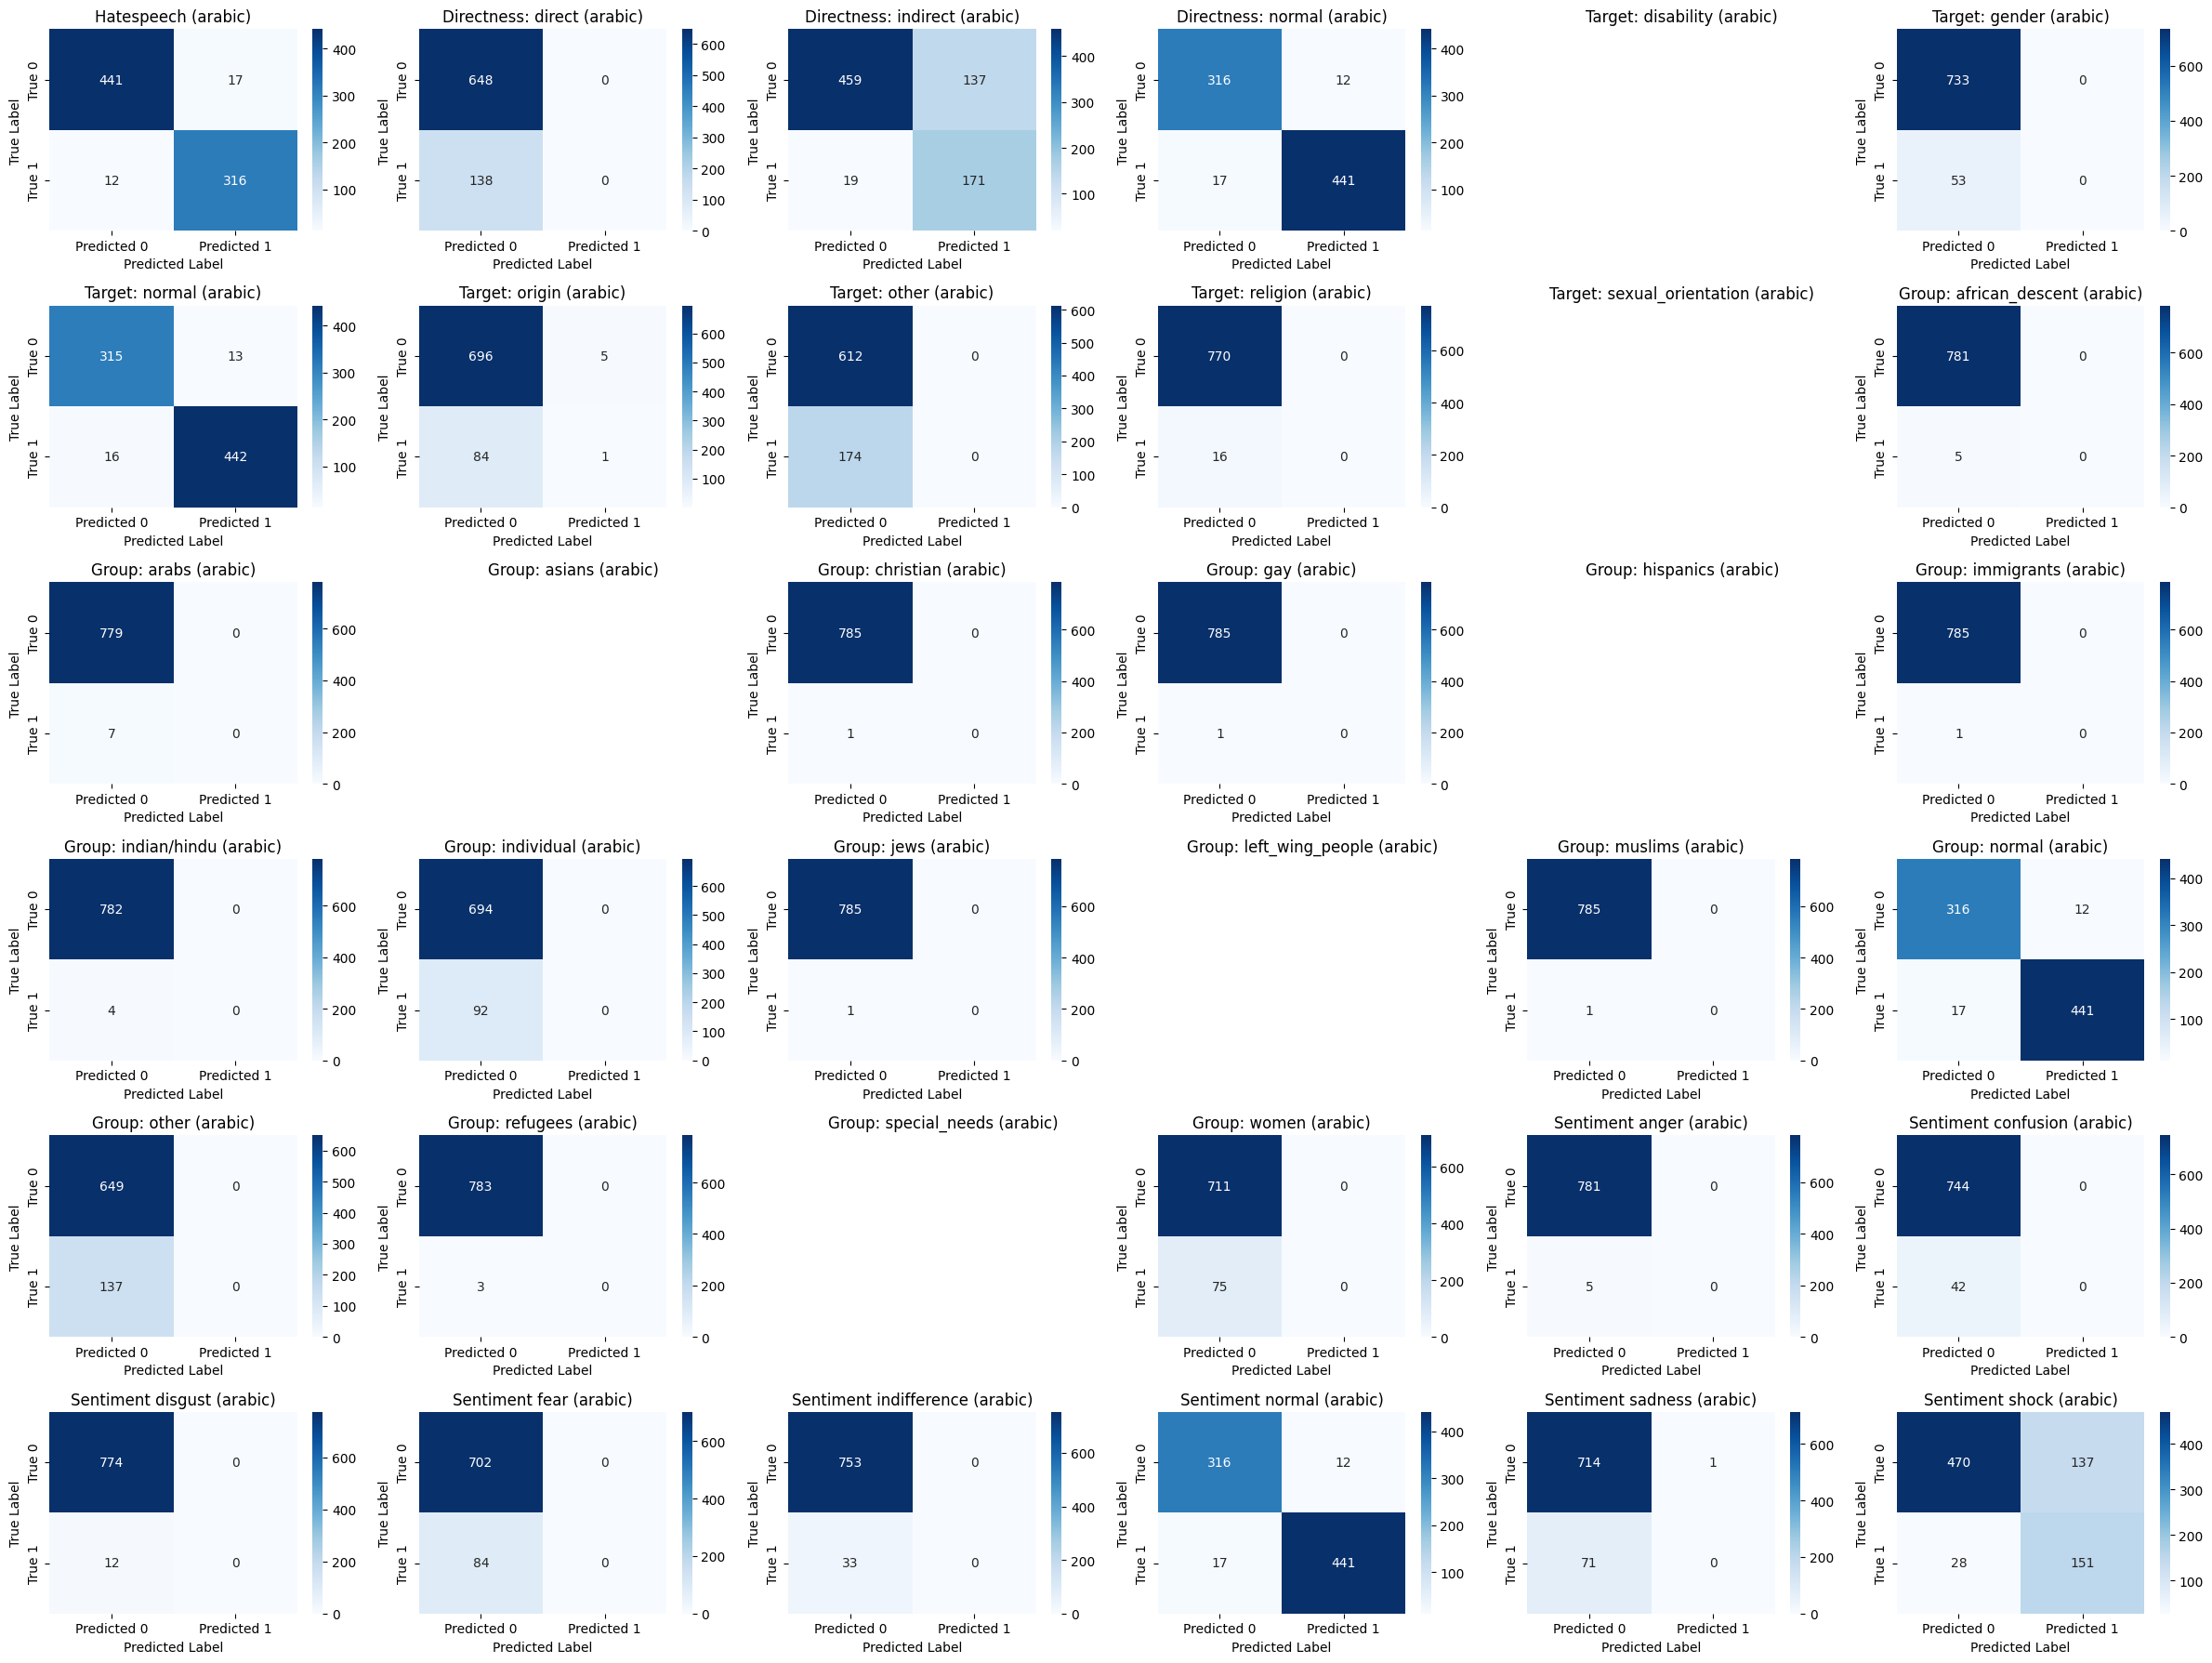


--- Analyzing english ---
Skipping group_label_3 in english: Only one true class present in true labels.


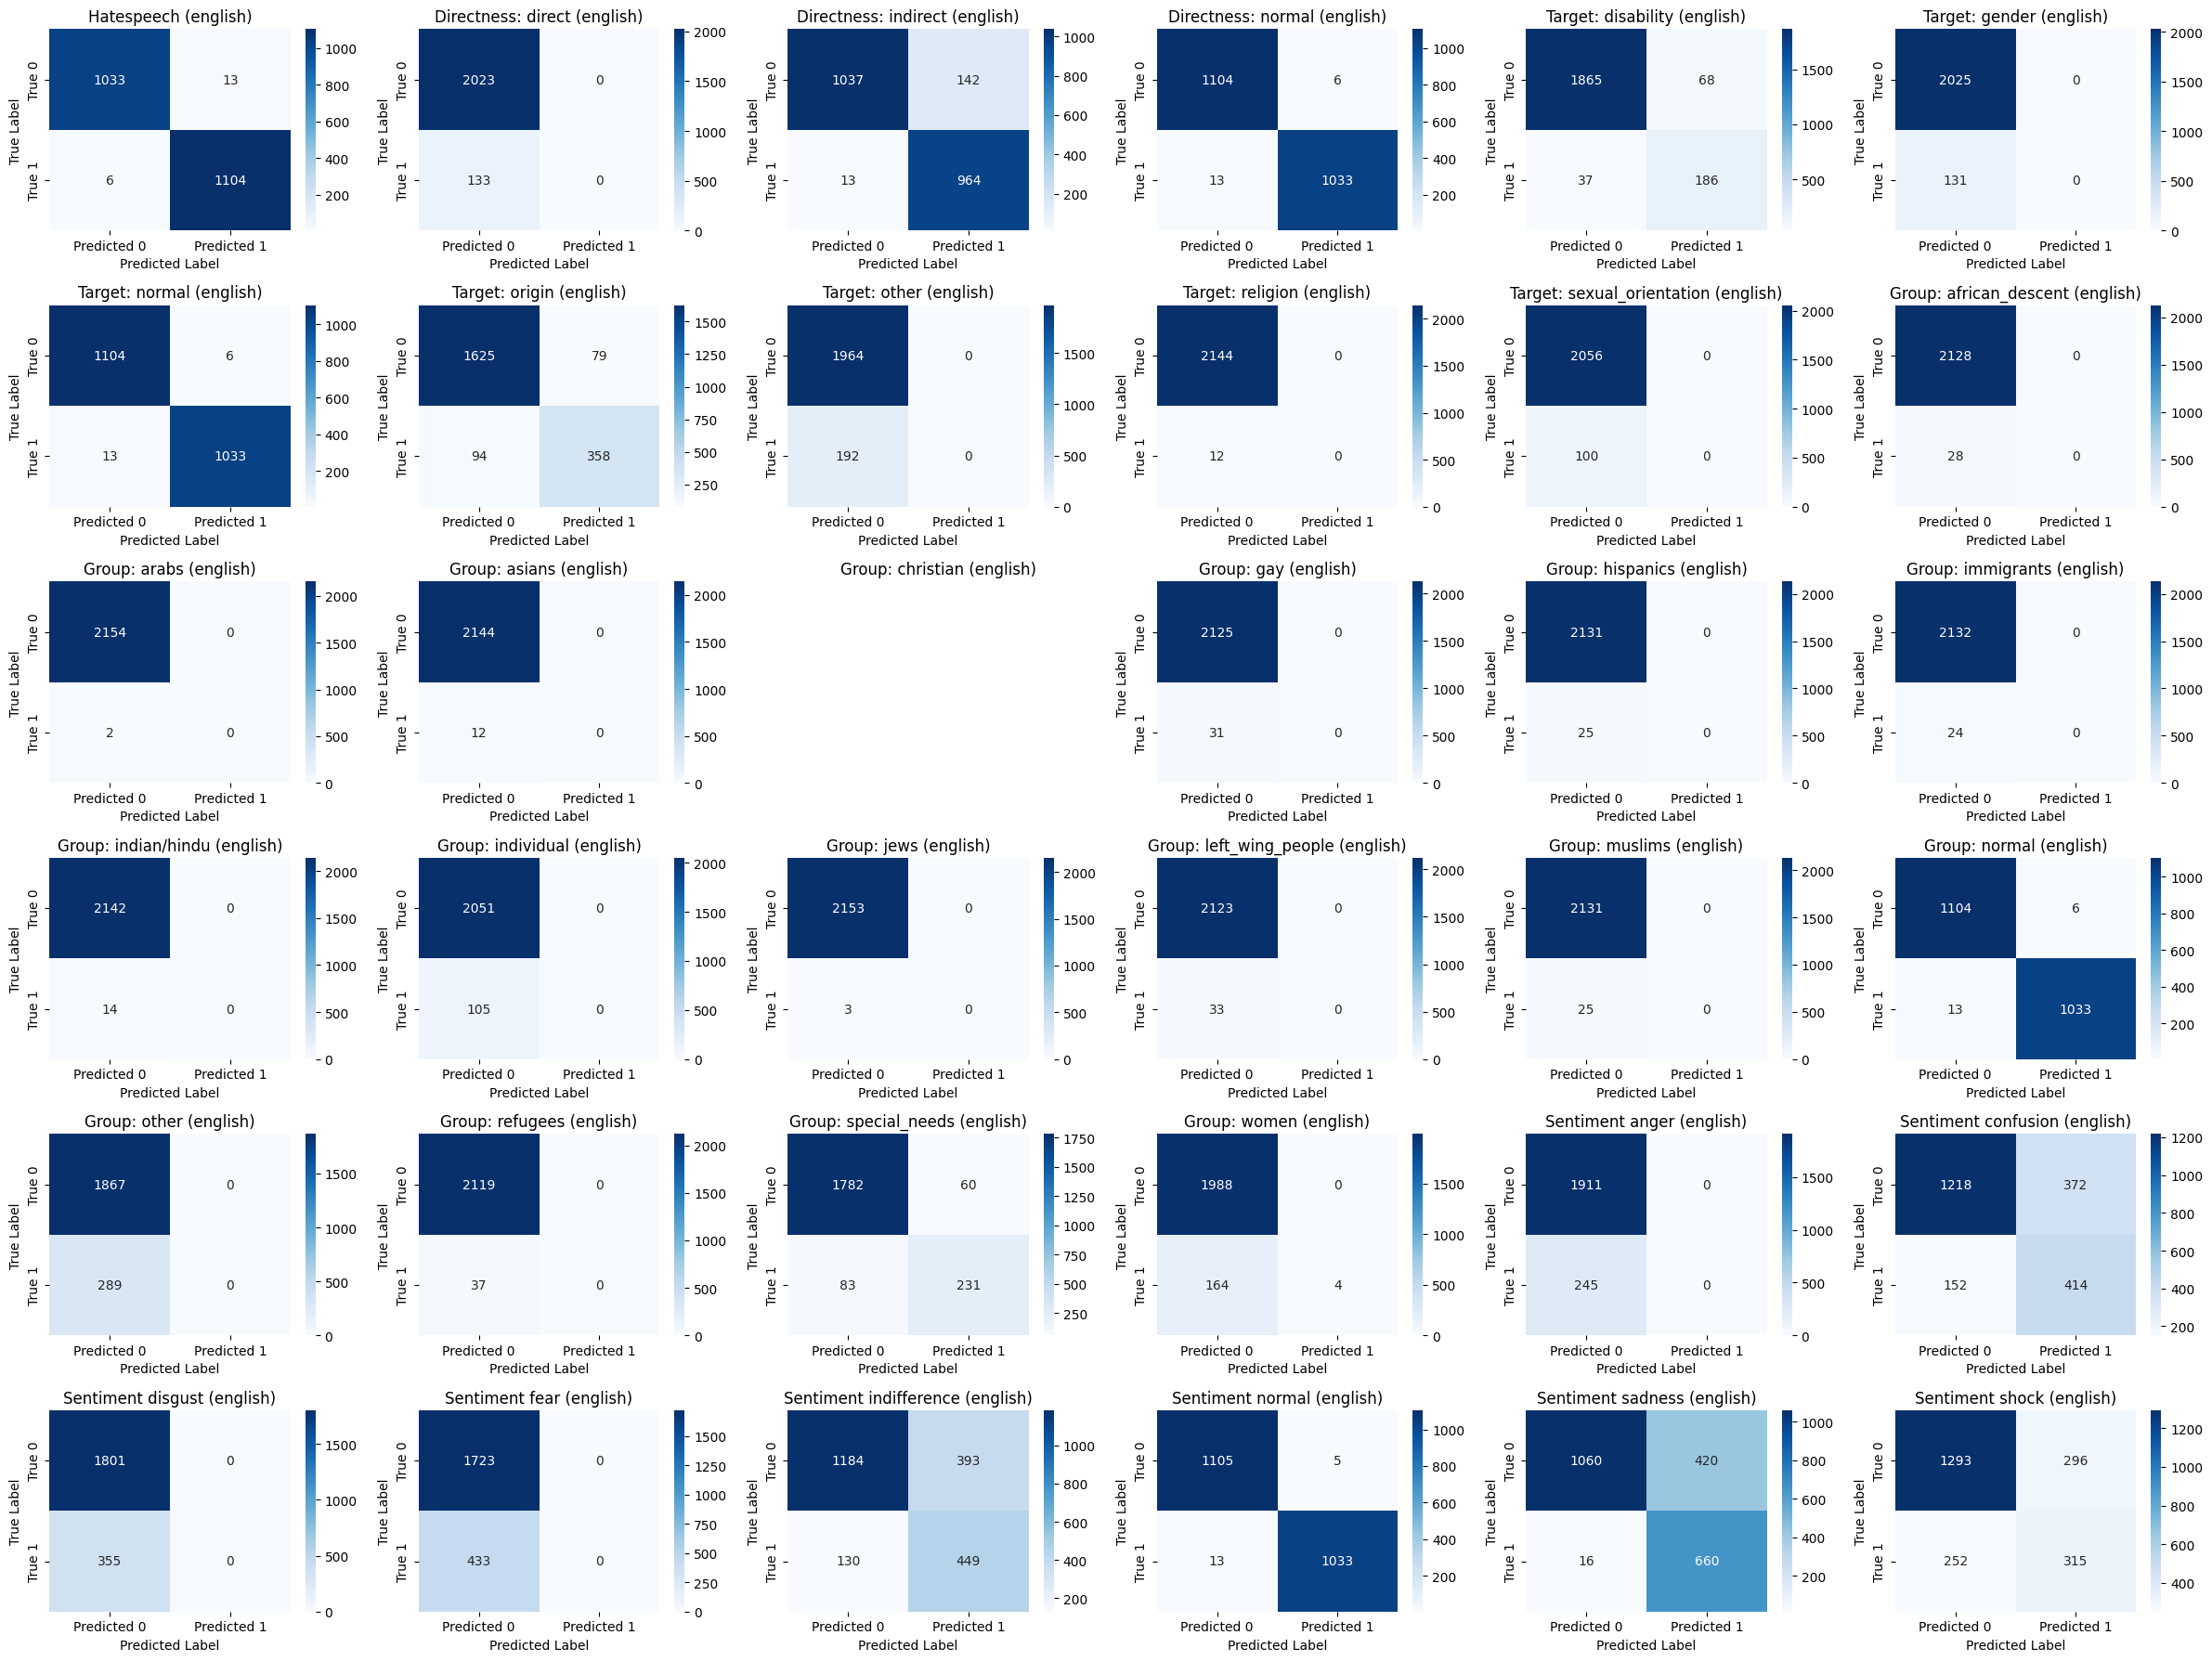


--- Analyzing french ---


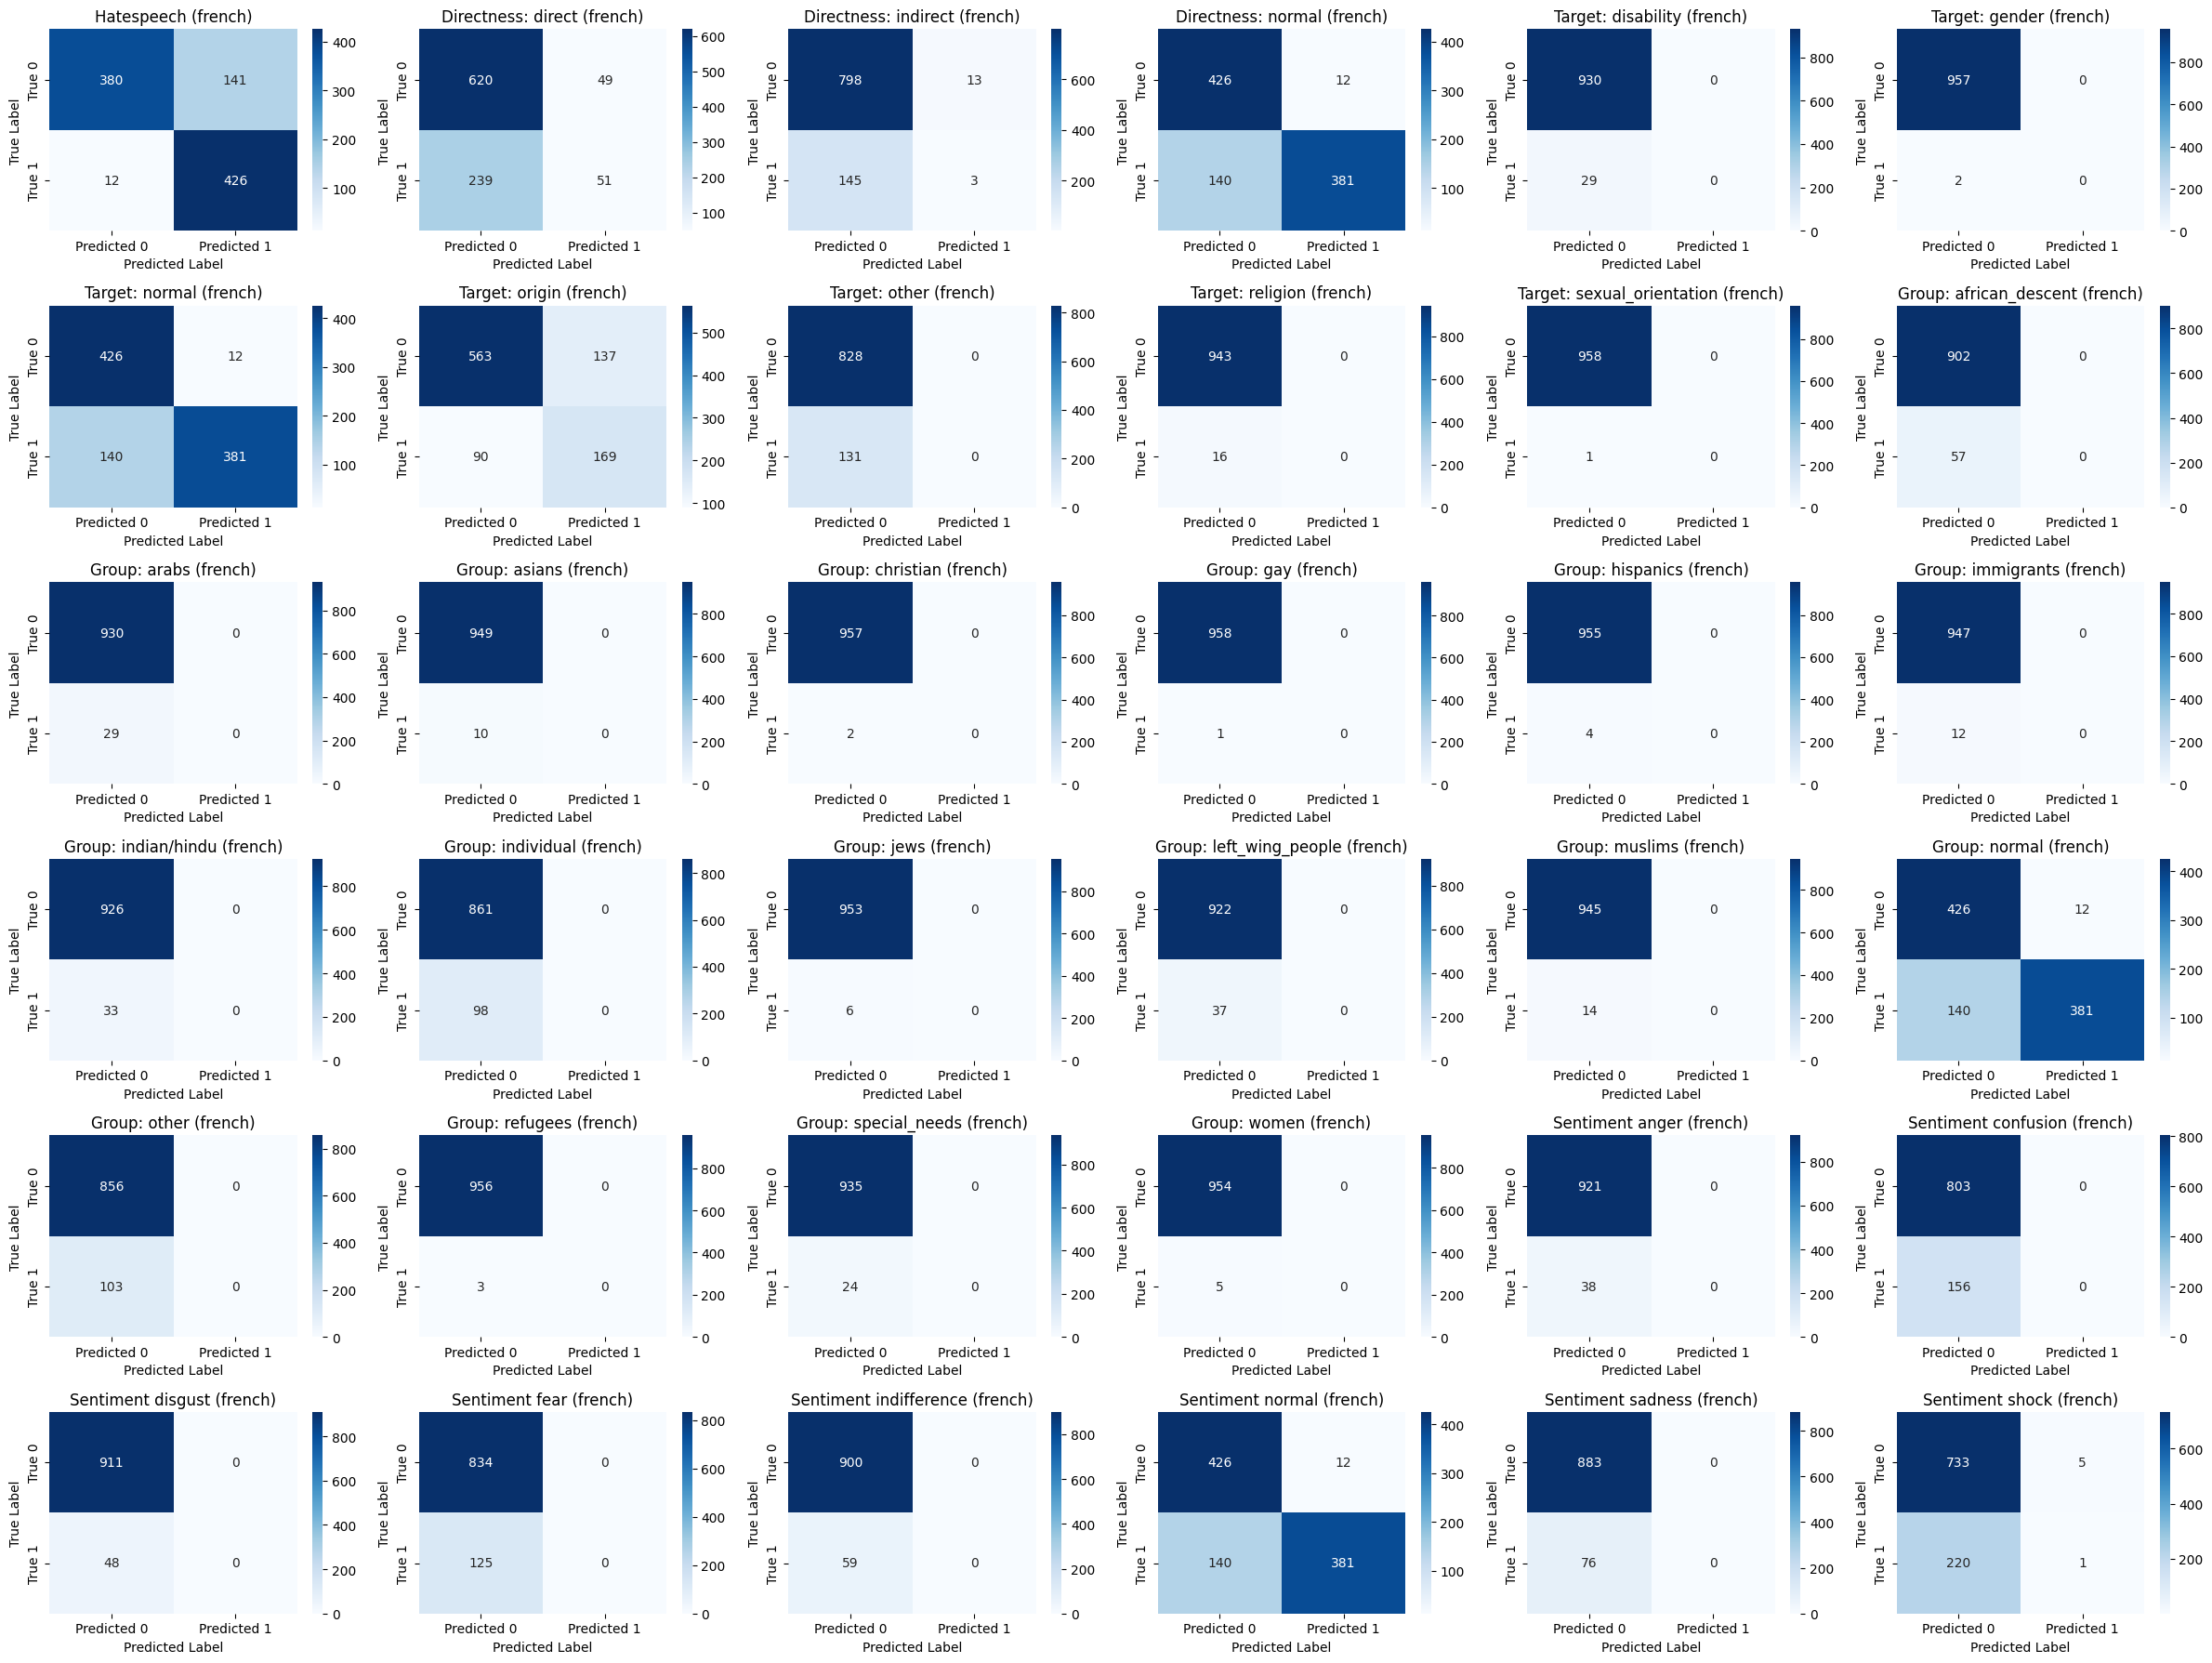

In [19]:
# Get predictions from the trainer
predictions = trainer.predict(encoded_dataset["validation"])

predicted_logits = predictions.predictions
true_labels_np = predictions.label_ids

# Apply sigmoid to get probabilities from logits
sigmoid = torch.nn.Sigmoid()
predicted_probs_np = sigmoid(torch.Tensor(predicted_logits)).numpy()

# Apply a threshold to get binary predictions
predicted_binary_labels_np = (predicted_probs_np >= 0.5).astype(int)

# Get the original language information for the validation dataset
val_languages = val_df['language'].values


# Define label name lists
sentiment_label_names = [
    "sentiment_anger",
    "sentiment_confusion",
    "sentiment_disgust",
    "sentiment_fear",
    "sentiment_indifference",
    "sentiment_normal",
    "sentiment_sadness",
    "sentiment_shock"
]
directness_label_names = [f'directness_label_{val}' for val in sorted(train_df['directness_label'].unique().tolist())]
target_label_names = [f'target_label_{val}' for val in sorted(train_df['target_label'].unique().tolist())]
group_label_names = [f'group_label_{val}' for val in sorted(train_df['group_label'].unique().tolist())]


# Get unique languages from the validation dataset
unique_languages = np.unique(val_languages)

# Define label categories and their corresponding lists of label names in the desired order
label_categories = {
    'hatespeech': ['hatespeech'],
    'directness': directness_label_names,
    'target': target_label_names,
    'group': group_label_names,
    'sentiment': sentiment_label_names,
}

# Define the mapping for multiclass labels to their descriptive names
multiclass_label_maps = {
    'directness': directness_map,
    'target': target_map,
    'group': group_map
}

# Function to plot confusion matrix (already defined, but including for clarity in this block)
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)

# Loop through each unique language
for lang in unique_languages:
    print(f"\n--- Analyzing {lang} ---")

    # Get indices for the current language in the validation dataset
    lang_indices = np.where(val_languages == lang)[0]

    # Calculate the total number of plots needed for this language
    total_plots_for_lang = sum(len(labels) for labels in label_categories.values())

    # Determine the grid size for subplots
    n_cols = 6  # Number of columns in the subplot grid
    n_rows = (total_plots_for_lang + n_cols - 1) // n_cols  # Calculate number of rows needed

    # Create a figure with subplots for this language
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    plot_index = 0 # Initialize plot index

    # Loop through each label category in the defined order
    for category_name, labels_list in label_categories.items():
        # Loop through each label within the category
        for label_name in labels_list:

            if plot_index < len(axes): # Ensure we don't exceed the number of subplots

                # Find the global index of this label in the all_binary_labels list
                try:
                    global_label_index = all_binary_labels.index(label_name)
                except ValueError:
                    print(f"Warning: Label '{label_name}' not found in all_binary_labels. Skipping.")
                    # Still add a placeholder title to the skipped plot if an axis is available
                    if plot_index < len(axes):
                         axes[plot_index].set_title(f'{label_name.replace("_", " ").capitalize()} ({lang}) - Data Missing')
                         axes[plot_index].axis('off') # Hide axis for empty plot
                    plot_index += 1
                    continue

                # Get the true and predicted binary labels for this specific label and language
                true_label_lang = true_labels_np[lang_indices, global_label_index]
                predicted_label_lang = predicted_binary_labels_np[lang_indices, global_label_index]

                # Determine the title for the plot
                if category_name in multiclass_label_maps and '_' in label_name:
                    # For multiclass labels, use the descriptive map
                    # Extract the original label value (e.g., '0' from 'directness_label_0')
                    parts = label_name.split('_')
                    original_value = parts[-1]
                    descriptive_name = multiclass_label_maps[category_name].get(original_value, original_value)
                    title = f'{category_name.capitalize()}: {descriptive_name} ({lang})'
                else:
                    # For binary/sentiment labels, use the label name directly
                    title = f'{label_name.replace("_", " ").capitalize()} ({lang})'

                # Check if there are at least two unique classes in the true labels
                if len(np.unique(true_label_lang)) < 2:
                    print(f"Skipping {label_name} in {lang}: Only one true class present in true labels.")
                    # Still add the title to the empty plot
                    if plot_index < len(axes):
                        axes[plot_index].set_title(title)
                        axes[plot_index].axis('off') # Hide axis for empty plot
                    plot_index += 1
                    continue


                # Calculate the confusion matrix
                cm_lang = confusion_matrix(true_label_lang, predicted_label_lang)

                # Plot the confusion matrix on the current subplot
                plot_confusion_matrix(cm_lang, title, axes[plot_index])

                plot_index += 1 # Increment plot index

    # Hide any unused subplots
    for k in range(plot_index, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()

## Summary:

### Data Analysis Key Findings
- The model's performance on the "hatespeech" label is consistent across all three languages (Arabic, English, and French), with a high number of true negatives and relatively few misclassifications.
- For the "directness" category, the model performs well in identifying "direct" and "normal" speech across all languages. However, it struggles with "indirect" speech, particularly in English and French, where it often misclassifies it.
- In the "target" category, the model shows varied performance. It is effective at identifying "normal" speech and some specific targets like "gender" and "sexual orientation" in English. However, for many other target categories across all languages, the data is sparse, leading to many empty or single-class plots.
- The "group" category suffers from significant data sparsity. While the model correctly identifies "normal" instances, most other group-specific labels lack sufficient data in the validation set for a meaningful performance evaluation, resulting in many skipped plots.
- For "sentiment," the model is highly effective at identifying "neutral" and "negative" sentiment across all languages. It shows some confusion with "positive" sentiment, especially in English and French, but the overall performance is strong.

### Insights or Next Steps
- Given the data sparsity for many "target" and "group" labels, it would be beneficial to either collect more data for these specific categories or consider grouping some of the less frequent labels to create more balanced classes for model training and evaluation.
- The model's difficulty in distinguishing "indirect" hate speech suggests that this is a challenging area. Future work could focus on feature engineering or using more advanced models specifically designed to understand nuanced and indirect language.


## Plot flattened confusion matrices


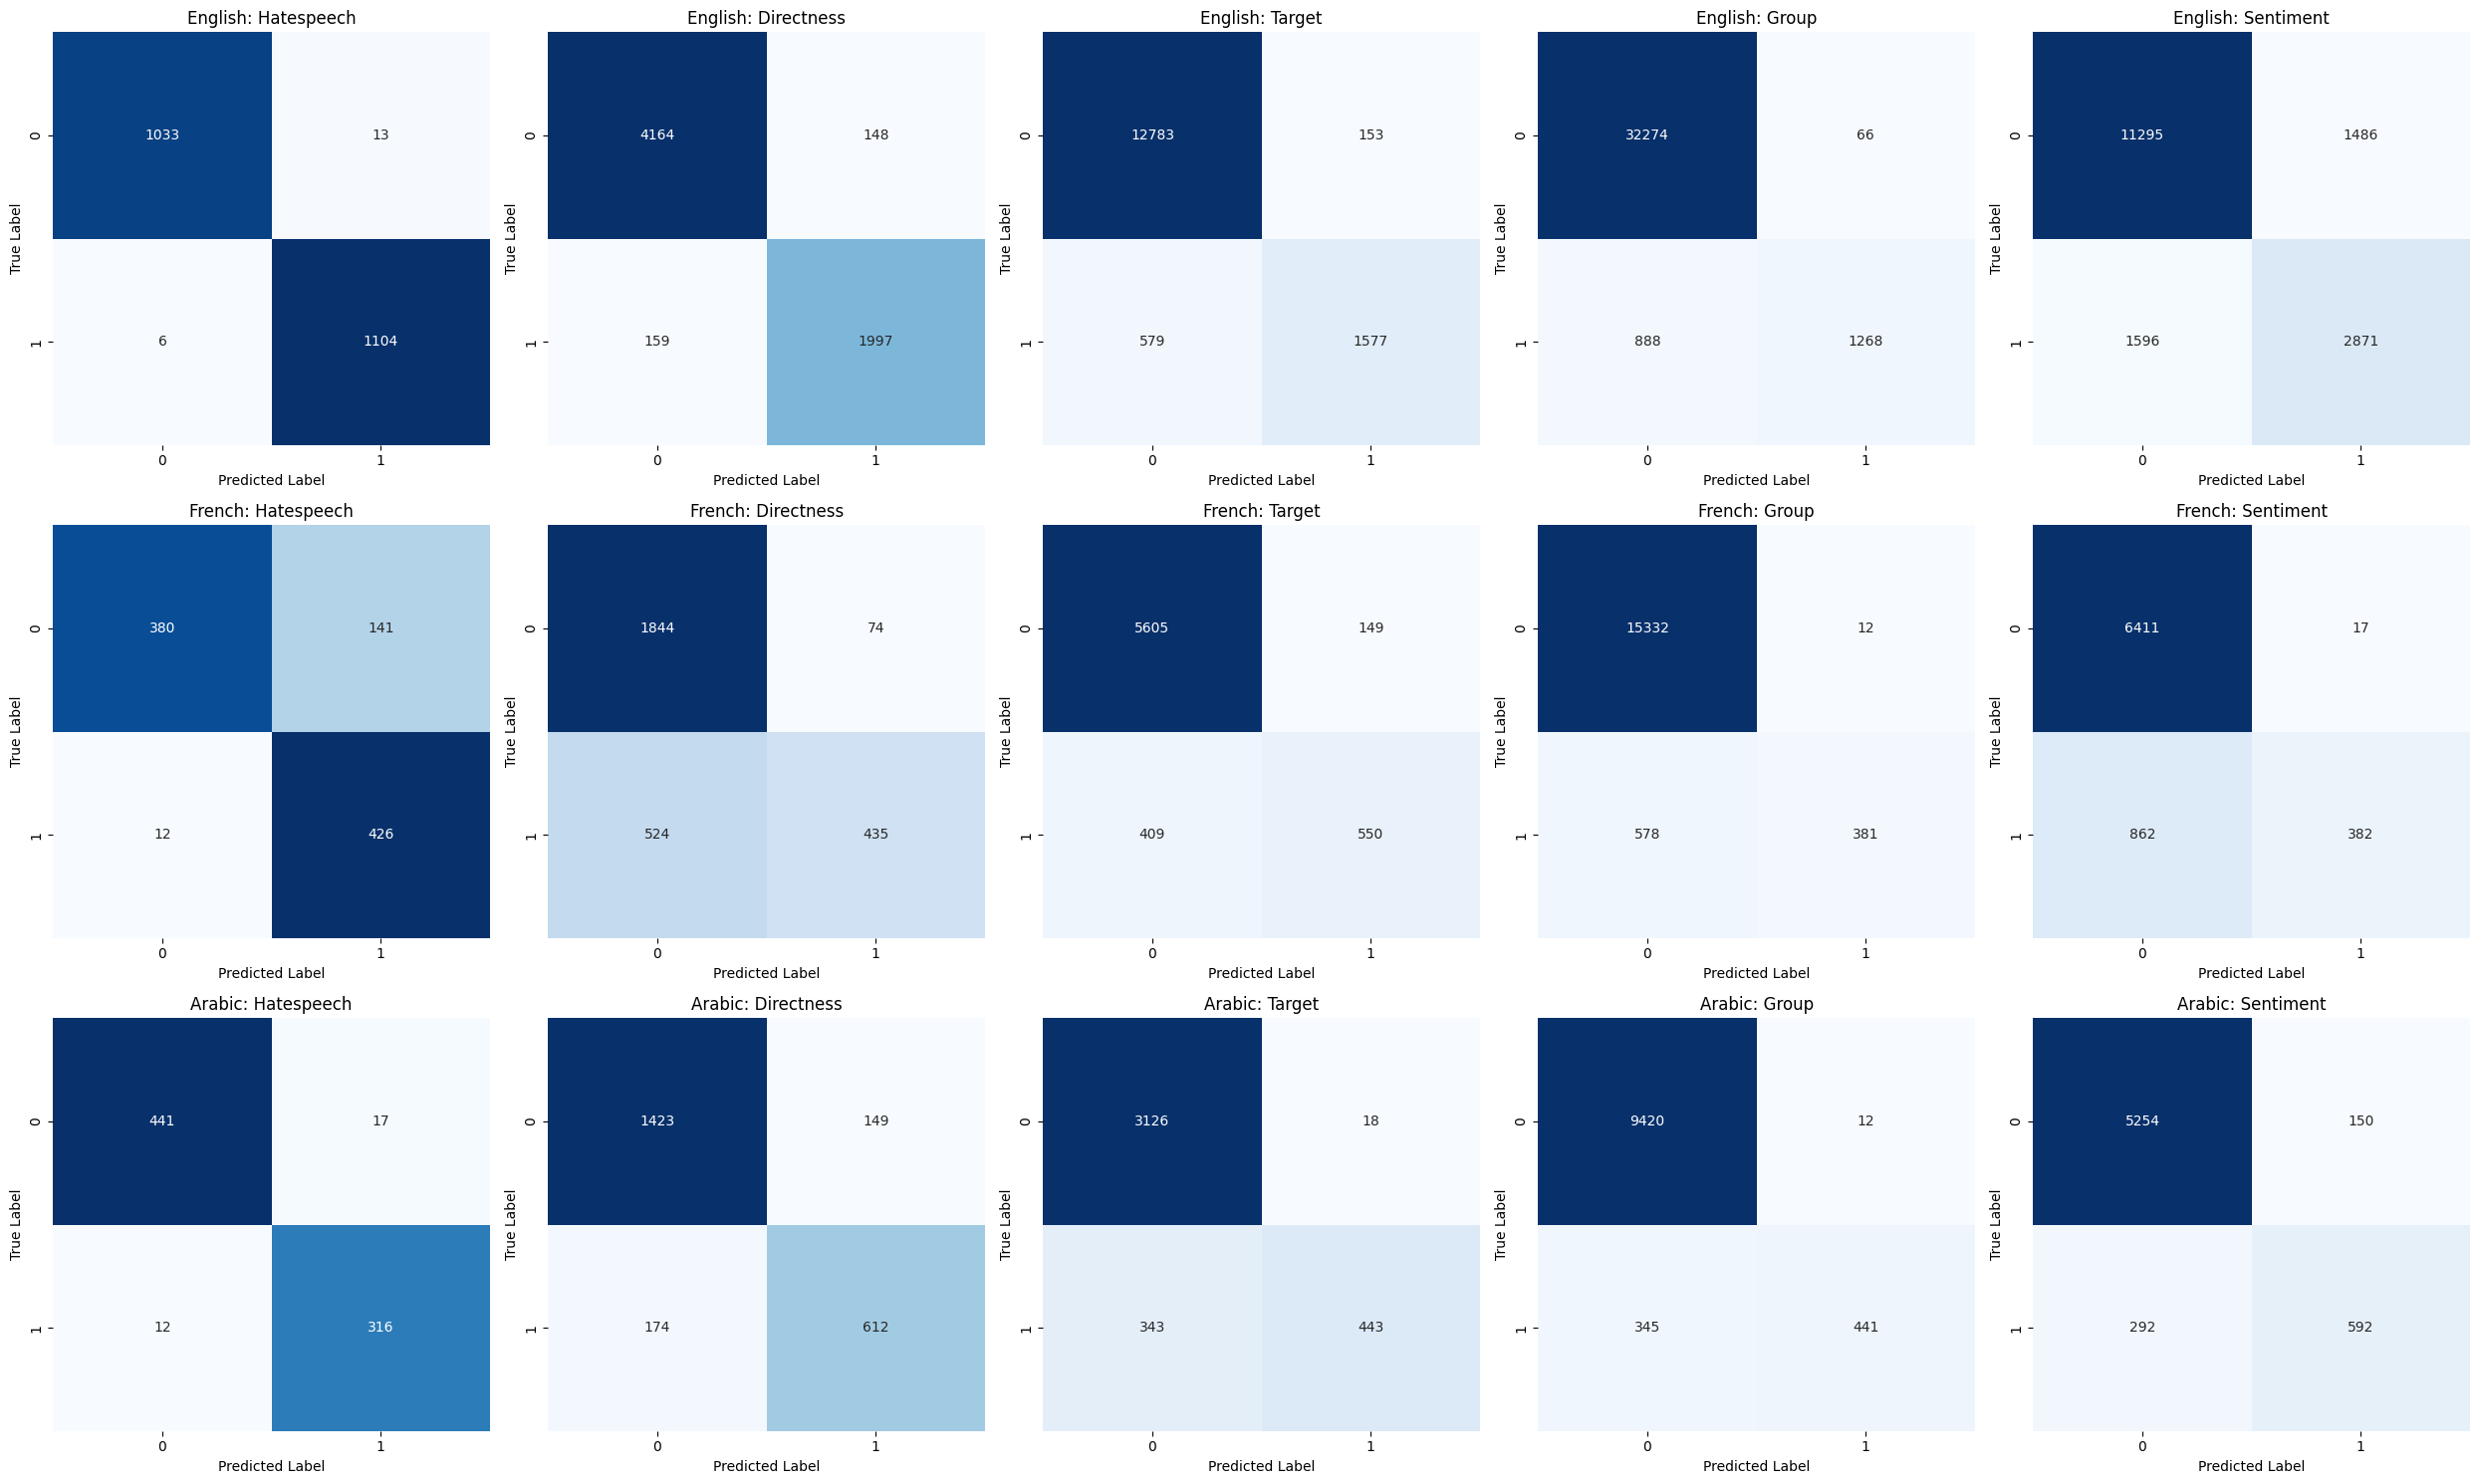

In [20]:
# Define the order of languages and label categories
language_order = ['english', 'french', 'arabic']
category_order = ['hatespeech', 'directness', 'target', 'group', 'sentiment']

# Create a figure and a 3x5 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15))

# Iterate through each language for the rows
for row_idx, lang in enumerate(language_order):
    # Iterate through each label category for the columns
    for col_idx, category_name in enumerate(category_order):
        ax = axes[row_idx, col_idx]

        # Initialize a flattened confusion matrix for the category
        flattened_cm = np.zeros((2, 2), dtype=int)

        # Get the list of labels for the current category
        labels_in_category = label_categories[category_name]

        # Get indices for the current language
        lang_indices = np.where(val_languages == lang)[0]

        # Iterate through each label within the category to aggregate the CM
        for label_name in labels_in_category:
            try:
                global_label_index = all_binary_labels.index(label_name)
            except ValueError:
                continue  # Skip if label not found

            true_label_lang = true_labels_np[lang_indices, global_label_index]
            predicted_label_lang = predicted_binary_labels_np[lang_indices, global_label_index]

            if len(np.unique(true_label_lang)) < 2:
                # Still need to handle the case where a plot is "empty"
                # but we continue to sum up for the flattened view
                continue

            cm_individual = confusion_matrix(true_label_lang, predicted_label_lang, labels=[0, 1])
            flattened_cm += cm_individual

        # Plot the flattened confusion matrix
        sns.heatmap(flattened_cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{lang.capitalize()}: {category_name.capitalize()}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings
*   A 3x5 grid of flattened confusion matrices was successfully generated, comparing the model's performance across three languages (English, French, and Arabic) and five label categories (hatespeech, directness, target, group, and sentiment).
*   Each subplot in the grid displays an aggregated confusion matrix for a specific language-category pair, offering a clear overview of the model's predictive accuracy in various contexts.
*   The visualizations are well-organized, with each plot correctly titled, providing a solid basis for analyzing the model's performance and understanding the performance differences between the non-hierarchical and hierarchical models.

### Insights or Next Steps
*   The generated flattened confusion matrices can be used to conduct a detailed error analysis for each language and label category, identifying specific areas where the model struggles.
*   Further investigation could involve comparing these confusion matrices with those from the hierarchical model to pinpoint the exact reasons for the performance discrepancy.


## Generalize lime predictor



Show correct and incorrect predictions for each label, for each category, for each language.

In [21]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2700115bb8d77f692e7929ca69c821630c2046942cb35afa2d03682d20f85e12
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [22]:
import lime
from lime import lime_text
import numpy as np

def lime_predictor(texts, label_index):
    """
    LIME predictor function for a specific label.

    Args:
        texts (list of str): A list of text strings to predict.
        label_index (int): The index of the target label.

    Returns:
        np.ndarray: A NumPy array of probabilities for the specified label.
    """
    # Tokenize the input texts
    encoding = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=150)
    # Move tensors to the same device as the model
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**encoding)

    # Apply sigmoid to get probabilities
    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits).cpu().numpy()

    # Return the probabilities for the specified label index
    # and for the positive class (1)
    return np.array([1 - probs[:, label_index], probs[:, label_index]]).T

In [32]:
explainer = lime_text.LimeTextExplainer(class_names=['not_label', 'is_label'])

# Store examples for explanation, with more specific categories
explanation_examples = {}

for lang in language_order:
    explanation_examples[lang] = {}
    for category_name in category_order:
        explanation_examples[lang][category_name] = {}

        labels_in_category = label_categories[category_name]
        lang_indices = np.where(val_languages == lang)[0]

        for label_name in labels_in_category:
            explanation_examples[lang][category_name][label_name] = {
                'correct_is_label': None,
                'correct_not_label': None,
                'incorrect_is_label': None, # False Positive
                'incorrect_not_label': None  # False Negative
            }

            try:
                global_label_index = all_binary_labels.index(label_name)
            except ValueError:
                continue

            true_label_lang = true_labels_np[lang_indices, global_label_index]
            predicted_label_lang = predicted_binary_labels_np[lang_indices, global_label_index]

            # Correctly predicted "is_label" (True Positive)
            correct_is_label_indices = np.where((true_label_lang == 1) & (predicted_label_lang == 1))[0]
            if len(correct_is_label_indices) > 0:
                example_idx = lang_indices[correct_is_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_is_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Correctly predicted "not_label" (True Negative)
            correct_not_label_indices = np.where((true_label_lang == 0) & (predicted_label_lang == 0))[0]
            if len(correct_not_label_indices) > 0:
                example_idx = lang_indices[correct_not_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_not_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Incorrectly predicted "is_label" (False Positive)
            incorrect_is_label_indices = np.where((true_label_lang == 0) & (predicted_label_lang == 1))[0]
            if len(incorrect_is_label_indices) > 0:
                example_idx = lang_indices[incorrect_is_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_is_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Incorrectly predicted "not_label" (False Negative)
            incorrect_not_label_indices = np.where((true_label_lang == 1) & (predicted_label_lang == 0))[0]
            if len(incorrect_not_label_indices) > 0:
                example_idx = lang_indices[incorrect_not_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_not_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }


print("Explanation examples have been collected for each label and prediction type.")

Explanation examples have been collected for each label and prediction type.


## Generate and display lime explanations



Show correct and incorrect predictions for each label, for each category, for each language.

In [33]:
import torch
torch.cuda.empty_cache()

# Move the model to CUDA (as requested by the user, assuming CUDA is available)
if torch.cuda.is_available():
    model.to('cuda')
    device = 'cuda'
else:
    model.to('cpu')
    device = 'cpu'

def lime_predictor(texts, label_index):
    """
    LIME predictor function for a specific label.
    Ensures tensors are on the same device as the model.
    """
    encoding = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=150)
    # Move encoding tensors to the same device as the model
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    # Move logits to CPU for numpy conversion
    probs = sigmoid(logits).cpu().numpy()

    return np.array([1 - probs[:, label_index], probs[:, label_index]]).T

# Define the mapping for multiclass labels to their descriptive names
multiclass_label_maps = {
    'directness': directness_map,
    'target': target_map,
    'group': group_map
}

# Loop through the collected explanation examples and generate LIME visualizations
for lang, categories in explanation_examples.items():
    for category_name, labels_data in categories.items():
        for label_name, examples in labels_data.items():
            for case, example_data in examples.items():
                if example_data:
                    text = example_data['text']
                    label_index = example_data['label_index']

                    # Determine the display title for the label
                    display_label_name = label_name
                    # Check if the label belongs to a multiclass category and has a mapping
                    if category_name in multiclass_label_maps and '_' in label_name:
                        # Extract the original label value (e.g., '0' from 'directness_label_0')
                        parts = label_name.split('_')
                        original_value = parts[-1]
                        # Get the descriptive name from the map
                        descriptive_name = multiclass_label_maps[category_name].get(original_value, original_value)
                        display_label_name = f"{category_name.capitalize()}: {descriptive_name}"
                    else:
                        # For binary/sentiment labels, just clean up the name
                        display_label_name = label_name.replace("_", " ").capitalize()


                    print(f"Generating explanation for: {lang.capitalize()} - {display_label_name} ({case.capitalize()})")

                    try:
                        explanation = explainer.explain_instance(
                            text,
                            lambda x: lime_predictor(x, label_index),
                            num_features=10,
                            num_samples=500,
                            labels=(1,) # Explain for the positive class
                        )

                        print(f"--- {lang.capitalize()}: {display_label_name} ({case.capitalize()}) ---")
                        display(explanation.show_in_notebook(text=True))

                    except Exception as e:
                        print(f"Could not generate explanation for {label_name} ({case}) in {lang}: {e}")
                        continue

Output hidden; open in https://colab.research.google.com to view.